У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.
Данные
В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:
data_train.csv: id, vas_id, buy_time, target
features.csv.zip: id, <feature_list> 

И тестовый набор:
data_test.csv: id, vas_id, buy_time
target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.
Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).
 sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation





Формат представления результата
Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
Код модели можно представить в виде jupyter-ноутбука. 
Презентация в формате .pdf, в которой необходимо отразить:
Информация о модели, ее параметрах, особенностях и основных результатах.
Обоснование выбора модели и ее сравнение с альтернативами.
Принцип составления индивидуальных предложений для выбранных абонентов.
Рекомендуемое количество слайдов – 5 – 10.
Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.


In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime

from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
 
from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RS_MODEL = 74
RS_HYPER = np.random.default_rng(61)

## Обробатка данных

Загрузим данные.

In [3]:
df_train = pd.read_csv('./data_train.csv')
df_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB


In [5]:
df_test = pd.read_csv('./data_test.csv')
df_test.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB


In [7]:
df_features = dd.read_csv('./features.csv', sep='\t')
df_features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [8]:
#df_features.shape[0].compute()

Количество записей в датаврейме признаков пользователей значительно привышает датафреймы с операциями по услугам. Мы может вырать только нужные нам записи.

In [9]:
df_features_train = df_features.loc[df_features['id'].isin(df_train['id'])].compute()

In [10]:
df_features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834168 entries, 13 to 12421
Columns: 256 entries, Unnamed: 0 to 252
dtypes: float64(253), int64(3)
memory usage: 1.6 GB


Изменим тип данных, чтобы уменьшить размер датафрейма.

In [50]:
def change_type (df):
    col  = df.columns
    float_col = []
    for i in col:
        if df[i].dtypes == 'float64':
            float_col.append(i)
    df[float_col] = df[float_col].astype(np.float32)        

In [12]:
change_type(df_features_train)
df_features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834168 entries, 13 to 12421
Columns: 256 entries, Unnamed: 0 to 252
dtypes: float32(253), int64(3)
memory usage: 830.5 MB


In [13]:
df_features_test = df_features.loc[df_features['id'].isin(df_test['id'])].compute()

In [14]:
df_features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72552 entries, 141 to 12403
Columns: 256 entries, Unnamed: 0 to 252
dtypes: float64(253), int64(3)
memory usage: 142.3 MB


Обединим таблицы услуг и данные пользователя. 

In [15]:
#df_train.loc[~df_train['id'].isin(df_features['id'])]

In [16]:
#df_test.loc[~df_test['id'].isin(df_features['id'])]

Из запрошеных пользователей нету неучтёных пользователей

In [17]:
df_features_train = df_train.merge(df_features_train, on=['id'], how='left')
df_features_train.head(2)

,Unnamed: 0_x,id,vas_id,buy_time_x,target,Unnamed: 0_y,buy_time_y,0,1,2,...,243,244,245,246,247,248,249,250,251,252
0,0,540968,8.0,1537131600,0.0,3756522,1541970000,-31.559971,327.360901,-45.500786,...,-845.37384,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0
1,1,1454121,4.0,1531688400,0.0,2735973,1531083600,547.270020,238.430893,533.329224,...,-972.37384,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0


In [18]:
df_features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860052 entries, 0 to 860051
Columns: 260 entries, Unnamed: 0_x to 252
dtypes: float32(253), float64(2), int64(5)
memory usage: 882.5 MB


При объединении таблиц были пользователи с несколькоми профилями с разным временем, они добылили новые записи. Убирем их, оставив ближайший по времени запись.

In [19]:
df_features_train.head()

,Unnamed: 0_x,id,vas_id,buy_time_x,target,Unnamed: 0_y,buy_time_y,0,1,2,...,243,244,245,246,247,248,249,250,251,252
0,0,540968,8.0,1537131600,0.0,3756522,1541970000,-31.559971,327.360901,-45.500786,...,-845.37384,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0
1,1,1454121,4.0,1531688400,0.0,2735973,1531083600,547.270020,238.430893,533.329224,...,-972.37384,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0
2,2,2458816,1.0,1534107600,0.0,3586550,1543179600,-92.139969,-95.469109,-106.080788,...,-977.37384,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
3,3,3535012,5.0,1535922000,0.0,1634974,1533502800,54.880028,12.970888,54.079212,...,-977.37384,-613.770813,-25.996269,-18.630449,-133.747726,-14.832889,-0.694429,-1.175933,-0.456140,0.0
4,4,1693214,1.0,1535922000,0.0,716515,1543179600,45.160030,295.240875,64.679214,...,-965.37384,-612.770813,-22.996269,-32.630447,-127.747726,-4.832889,-0.694429,-12.175933,-0.456140,0.0


In [20]:
df_dupl = df_features_train[df_features_train[['id', 'Unnamed: 0_x']].duplicated(keep=False)] \
                                [['Unnamed: 0_x', 'id', 'buy_time_x', 'buy_time_y']]
df_dupl

,Unnamed: 0_x,id,buy_time_x,buy_time_y
8,8,2000856,1534712400,1531688400
9,8,2000856,1534712400,1531083600
58,57,3577738,1532293200,1540760400
59,57,3577738,1532293200,1537736400
63,61,203194,1532293200,1542574800
...,...,...,...,...
859986,831589,2524068,1546203600,1546203600
860000,831603,3897343,1546203600,1544994000
860001,831603,3897343,1546203600,1532293200
860029,831631,3431643,1546203600,1547413200


In [21]:
df_dupl['diff'] = abs(df_dupl['buy_time_x'] - df_dupl['buy_time_y'])
df_dupl.head(2)

,Unnamed: 0_x,id,buy_time_x,buy_time_y,diff
8,8,2000856,1534712400,1531688400,3024000
9,8,2000856,1534712400,1531083600,3628800


In [22]:
df_dupl.sort_values(by = ['Unnamed: 0_x', 'diff'], inplace=True)
df_dupl.head(2)

,Unnamed: 0_x,id,buy_time_x,buy_time_y,diff
8,8,2000856,1534712400,1531688400,3024000
9,8,2000856,1534712400,1531083600,3628800


In [23]:
df_dupl = df_dupl.loc[df_dupl[['id', 'Unnamed: 0_x']].duplicated()]
df_dupl.head(2)

,Unnamed: 0_x,id,buy_time_x,buy_time_y,diff
9,8,2000856,1534712400,1531083600,3628800
58,57,3577738,1532293200,1540760400,8467200


In [24]:
df_features_train = df_features_train.loc[~df_features_train.index.isin(df_dupl.index)]
df_features_train

,Unnamed: 0_x,id,vas_id,buy_time_x,target,Unnamed: 0_y,buy_time_y,0,1,2,...,243,244,245,246,247,248,249,250,251,252
0,0,540968,8.0,1537131600,0.0,3756522,1541970000,-31.559971,327.360901,-45.500786,...,-845.373840,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0
1,1,1454121,4.0,1531688400,0.0,2735973,1531083600,547.270020,238.430893,533.329224,...,-972.373840,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0
2,2,2458816,1.0,1534107600,0.0,3586550,1543179600,-92.139969,-95.469109,-106.080788,...,-977.373840,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
3,3,3535012,5.0,1535922000,0.0,1634974,1533502800,54.880028,12.970888,54.079212,...,-977.373840,-613.770813,-25.996269,-18.630449,-133.747726,-14.832889,-0.694429,-1.175933,-0.456140,0.0
4,4,1693214,1.0,1535922000,0.0,716515,1543179600,45.160030,295.240875,64.679214,...,-965.373840,-612.770813,-22.996269,-32.630447,-127.747726,-4.832889,-0.694429,-12.175933,-0.456140,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860047,831648,3812226,2.0,1546203600,0.0,3598646,1532898000,29.750029,6.200888,24.279215,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
860048,831649,2480469,2.0,1546203600,0.0,1126545,1532293200,-89.179970,-56.499111,-103.120789,...,-66.373848,-321.770782,-25.996269,62.369553,1167.252319,41.167110,-0.694429,54.824066,-0.456140,0.0
860049,831650,158236,2.0,1546203600,0.0,3755060,1538946000,-96.799973,62.140888,-110.740784,...,-683.373840,-470.770782,-25.996269,-37.630447,99.252274,178.167114,-0.694429,191.824066,-0.456140,0.0
860050,831651,1825525,2.0,1546203600,0.0,253884,1533502800,-96.799973,-81.919113,-110.740784,...,1018.626160,1367.229248,-24.996269,-35.630447,-237.747726,-21.832888,-0.694429,-8.175933,-0.456140,1.0


Лишнии пользоватили были убраны. Востановим индаксы и убирем лишнии колонки.

In [25]:
df_features_train.sort_values(by = 'Unnamed: 0_x', inplace=True)
df_features_train.reset_index(drop=True, inplace=True)
df_features_train.drop(columns=['Unnamed: 0_x', 'id', 'Unnamed: 0_y'], inplace=True)
df_features_train

,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,8.0,1537131600,0.0,1541970000,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,...,-845.373840,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0
1,4.0,1531688400,0.0,1531083600,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,...,-972.373840,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0
2,1.0,1534107600,0.0,1543179600,-92.139969,-95.469109,-106.080788,-139.596802,-111.498245,-142.901794,...,-977.373840,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
3,5.0,1535922000,0.0,1533502800,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,...,-977.373840,-613.770813,-25.996269,-18.630449,-133.747726,-14.832889,-0.694429,-1.175933,-0.456140,0.0
4,1.0,1535922000,0.0,1543179600,45.160030,295.240875,64.679214,344.283203,59.261753,323.178223,...,-965.373840,-612.770813,-22.996269,-32.630447,-127.747726,-4.832889,-0.694429,-12.175933,-0.456140,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,2.0,1546203600,0.0,1532898000,29.750029,6.200888,24.279215,-37.936798,18.861753,-59.041790,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
831649,2.0,1546203600,0.0,1532293200,-89.179970,-56.499111,-103.120789,-109.106796,-108.538246,-130.211792,...,-66.373848,-321.770782,-25.996269,62.369553,1167.252319,41.167110,-0.694429,54.824066,-0.456140,0.0
831650,2.0,1546203600,0.0,1538946000,-96.799973,62.140888,-110.740784,9.533202,-116.158249,-11.571790,...,-683.373840,-470.770782,-25.996269,-37.630447,99.252274,178.167114,-0.694429,191.824066,-0.456140,0.0
831651,2.0,1546203600,0.0,1533502800,-96.799973,-81.919113,-110.740784,-128.596802,-116.158249,-76.821793,...,1018.626160,1367.229248,-24.996269,-35.630447,-237.747726,-21.832888,-0.694429,-8.175933,-0.456140,1.0


Поменяем форматы даты в нашем датафрейме.

In [26]:
df_features_train['buy_time_x'] = df_features_train['buy_time_x'].apply(lambda x: datetime.fromtimestamp(x))
df_features_train['buy_time_y'] = df_features_train['buy_time_y'].apply(lambda x: datetime.fromtimestamp(x))
df_features_train.head(2)

,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,8.0,2018-09-17,0.0,2018-11-12,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,...,-845.37384,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0
1,4.0,2018-07-16,0.0,2018-07-09,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,...,-972.37384,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0


In [27]:
df_features_train['buy_time_x'].min()

Timestamp('2018-07-09 00:00:00')

In [28]:
df_features_train['buy_time_x'].max()

Timestamp('2018-12-31 00:00:00')

В данных есть только день записи данных. Преобразуем дататайм данные.

In [29]:
df_features_train['year_var'] = df_features_train['buy_time_x'].dt.year
df_features_train['month_var'] = df_features_train['buy_time_x'].dt.month
df_features_train['day_var'] = df_features_train['buy_time_x'].dt.day

df_features_train['year_feat'] = df_features_train['buy_time_y'].dt.year
df_features_train['month_feat'] = df_features_train['buy_time_y'].dt.month
df_features_train['day_feat'] = df_features_train['buy_time_y'].dt.day

In [30]:
df_features_train.drop(columns=['buy_time_x', 'buy_time_y'], inplace=True)
df_features_train

,vas_id,target,0,1,2,3,4,5,6,7,...,249,250,251,252,year_var,month_var,day_var,year_feat,month_feat,day_feat
0,8.0,0.0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,...,7.305572,-12.175933,21.543859,0.0,2018,9,17,2018,11,12
1,4.0,0.0,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,...,-0.694429,-11.175933,-0.456140,0.0,2018,7,16,2018,7,9
2,1.0,0.0,-92.139969,-95.469109,-106.080788,-139.596802,-111.498245,-142.901794,-16.08618,-65.076096,...,-0.694429,-12.175933,-0.456140,0.0,2018,8,13,2018,11,26
3,5.0,0.0,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,60.17382,87.453903,...,-0.694429,-1.175933,-0.456140,0.0,2018,9,3,2018,8,6
4,1.0,0.0,45.160030,295.240875,64.679214,344.283203,59.261753,323.178223,-16.08618,-65.076096,...,-0.694429,-12.175933,-0.456140,0.0,2018,9,3,2018,11,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,2.0,0.0,29.750029,6.200888,24.279215,-37.936798,18.861753,-59.041790,-16.08618,-65.076096,...,-0.694429,-12.175933,-0.456140,0.0,2018,12,31,2018,7,30
831649,2.0,0.0,-89.179970,-56.499111,-103.120789,-109.106796,-108.538246,-130.211792,-16.08618,-65.076096,...,-0.694429,54.824066,-0.456140,0.0,2018,12,31,2018,7,23
831650,2.0,0.0,-96.799973,62.140888,-110.740784,9.533202,-116.158249,-11.571790,-16.08618,405.243896,...,-0.694429,191.824066,-0.456140,0.0,2018,12,31,2018,10,8
831651,2.0,0.0,-96.799973,-81.919113,-110.740784,-128.596802,-116.158249,-76.821793,-16.08618,-65.076096,...,-0.694429,-8.175933,-0.456140,1.0,2018,12,31,2018,8,6


## Создание базлайна. Выбор модели.

Разделим наши данные. Так как данные могут ненятся со временем, для валидации разделим датафраме по времени по тому же принцепу что и используется в задании. Для валидации возьмем один месяц.

In [31]:
X_train = df_features_train.loc[df_features_train['month_var'] < 12].drop(columns='target')
y_train = df_features_train.loc[df_features_train['month_var'] < 12, 'target']

X_test = df_features_train.loc[df_features_train['month_var'] >= 12].drop(columns='target')
y_test = df_features_train.loc[df_features_train['month_var'] >= 12, 'target']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(584073, 260) (584073,) (247580, 260) (247580,)


In [32]:
print(df_features_train['target'].value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

0.0    771467
1.0     60186
Name: target, dtype: int64
0.0    546089
1.0     37984
Name: target, dtype: int64
0.0    225378
1.0     22202
Name: target, dtype: int64


Соотношение таргета при разделении сильно не изменилось.

Определим оптимальные гиперпараметры с помощью hyperopt.

In [33]:
def hyperopt_tree_score(params):
    model_tree = DecisionTreeClassifier(random_state=RS_MODEL,  **params)
    
    model_tree.fit(X_train, y_train)

    y_pred = model_tree.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')

    print(score, params)
    return -score
 

space_tree = {
            'max_depth':  hp.choice('max_depth', np.arange(1, 15, dtype=int)),
            'min_samples_leaf':  hp.choice('min_samples_leaf', np.arange(5, 50, dtype=int)),
}

    
#best_tree = fmin(fn=hyperopt_tree_score, space=space_tree, algo=tpe.suggest, max_evals=15, rstate=RS_HYPER)
#print('best:')
#print(best_tree)

0.5017144377987071                                                                                                     
{'max_depth': 13, 'min_samples_leaf': 9}                                                                               
0.4651823264590572                                                                                                     
{'max_depth': 6, 'min_samples_leaf': 26}                                                                               
0.4765285712473412                                                                                                     
{'max_depth': 1, 'min_samples_leaf': 36}                                                                               
0.5114362248697436                                                                                                     
{'max_depth': 14, 'min_samples_leaf': 13}                                                                              
0.46517463855462493                                                                                                    
{'max_depth': 6, 'min_samples_leaf': 17}                                                                               
0.480358317148554                                                                                                      
{'max_depth': 8, 'min_samples_leaf': 16}                                                                               
0.43474908477282326                                                                                                    
{'max_depth': 4, 'min_samples_leaf': 40}                                                                               
0.2375059660402458                                                                                                     
{'max_depth': 2, 'min_samples_leaf': 42}                                                                               
0.4988550920936065                                                                                                     
{'max_depth': 13, 'min_samples_leaf': 11}                                                                              
0.43474908477282326                                                                                                    
{'max_depth': 4, 'min_samples_leaf': 15}                                                                               
0.43474908477282326                                                                                                    
{'max_depth': 3, 'min_samples_leaf': 30}                                                                               
0.4823308858927947                                                                                                     
{'max_depth': 7, 'min_samples_leaf': 10}                                                                               
0.4961523321168724                                                                                                     
{'max_depth': 5, 'min_samples_leaf': 17}                                                                               
0.4861286431132398                                                                                                     
{'max_depth': 10, 'min_samples_leaf': 48}                                                                              
0.4765285712473412                                                                                                     
{'max_depth': 1, 'min_samples_leaf': 39}                                                                               
100%|███████████████████████████████████████████████| 15/15 [06:21<00:00, 25.42s/trial, best loss: -0.5114362248697436]
best:
{'max_depth': 13, 'min_samples_leaf': 8}

In [34]:
model_tree = DecisionTreeClassifier(random_state=RS_MODEL, 
                                min_samples_leaf=13,
                                max_depth=14,
                                )
model_tree.fit(X_train, y_train)

y_pred = model_tree.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.5140958793007488

0.5140958793007488

In [36]:
def hyperopt_lgbm_score(params):
    model_lgbm = LGBMClassifier(random_state=RS_MODEL, **params)
    
    model_lgbm.fit(X_train, y_train)

    y_pred = model_lgbm.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')

    print(score, params)
    return -score
 
 
space_lgbm = {
            'n_estimators': hp.choice('n_estimators', range(300, 1200)),
            'reg_lambda': hp.quniform('reg_lambda', 0.25, 3.0, 0.25),
            'max_depth':  hp.choice('max_depth', np.arange(1, 10, dtype=int)),
            'num_leaves':  hp.choice('num_leaves', np.arange(5, 50, dtype=int)),
}
 
#best_lgbm = fmin(fn=hyperopt_lgbm_score, space=space_lgbm, algo=tpe.suggest, max_evals=15, rstate=RS_HYPER)
#print('best:')
#print(best_lgbm)

0.5190180103666006                                                                                                     
{'max_depth': 7, 'n_estimators': 623, 'num_leaves': 40, 'reg_lambda': 1.75}                                            
0.5421935207999706                                                                                                     
{'max_depth': 14, 'n_estimators': 1169, 'num_leaves': 47, 'reg_lambda': 1.75}                                          
0.6777681386173161                                                                                                     
{'max_depth': 1, 'n_estimators': 736, 'num_leaves': 15, 'reg_lambda': 3.0}                                             
0.5270207200012507                                                                                                     
{'max_depth': 9, 'n_estimators': 866, 'num_leaves': 26, 'reg_lambda': 0.5}                                             
0.5312220244493806                                                                                                     
{'max_depth': 8, 'n_estimators': 926, 'num_leaves': 21, 'reg_lambda': 0.25}                                            
0.5447337758812474                                                                                                     
{'max_depth': 12, 'n_estimators': 1120, 'num_leaves': 48, 'reg_lambda': 0.5}                                           
0.5371366769692798                                                                                                     
{'max_depth': 7, 'n_estimators': 850, 'num_leaves': 16, 'reg_lambda': 1.5}                                             
0.6361144138477759                                                                                                     
{'max_depth': 11, 'n_estimators': 939, 'num_leaves': 5, 'reg_lambda': 2.0}                                             
0.6318649134943515                                                                                                     
{'max_depth': 10, 'n_estimators': 591, 'num_leaves': 9, 'reg_lambda': 1.0}                                             
0.6461503416655336                                                                                                     
{'max_depth': 2, 'n_estimators': 1182, 'num_leaves': 26, 'reg_lambda': 0.5}                                            
0.5247220646044378                                                                                                     
{'max_depth': 13, 'n_estimators': 894, 'num_leaves': 25, 'reg_lambda': 1.25}                                           
0.5157694903752904                                                                                                     
{'max_depth': 10, 'n_estimators': 346, 'num_leaves': 46, 'reg_lambda': 2.75}                                           
0.5497292633604849                                                                                                     
{'max_depth': 5, 'n_estimators': 1075, 'num_leaves': 29, 'reg_lambda': 0.75}                                           
0.6777681386173161                                                                                                     
{'max_depth': 1, 'n_estimators': 801, 'num_leaves': 17, 'reg_lambda': 2.5}                                             
0.548287741411421                                                                                                      
{'max_depth': 5, 'n_estimators': 859, 'num_leaves': 29, 'reg_lambda': 0.25}                                            
100%|███████████████████████████████████████████████| 15/15 [20:11<00:00, 80.75s/trial, best loss: -0.6777681386173161]
best:
{'max_depth': 0, 'n_estimators': 436, 'num_leaves': 10, 'reg_lambda': 3.0}



In [37]:
model_lgbm = LGBMClassifier(random_state=RS_MODEL, 
                                n_estimators=450,
                                num_leaves=17,
                                max_depth=1,
                                reg_lambda=2.5 
                                )
model_lgbm.fit(X_train, y_train)

y_pred = model_lgbm.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.6877665753360113

0.6877665753360113

In [39]:
def hyperopt_cat_score(params):
    model_cat = CatBoostClassifier(random_state=RS_MODEL, silent = True,  **params)
    
    model_cat.fit(X_train, y_train)

    y_pred = model_cat.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')

    print(score, params)
    return -score
 
 
space_cat = {
            'n_estimators': hp.choice('n_estimators', range(300, 1200)),
            'reg_lambda': hp.quniform('reg_lambda', 0.25, 3.0, 0.25),
            'max_depth':  hp.choice('max_depth', np.arange(1, 15, dtype=int)),

}
 
#best_cat = fmin(fn=hyperopt_cat_score, space=space_cat, algo=tpe.suggest, max_evals=15, rstate=RS_HYPER)
#print('best:')
#print(best_cat)

0.693019621129839                                                                                                      
{'max_depth': 2, 'n_estimators': 467, 'reg_lambda': 0.75}                                                              
0.7016226057131056                                                                                                     
{'max_depth': 10, 'n_estimators': 1071, 'reg_lambda': 2.0}                                                             
0.7104865327153145                                                                                                     
{'max_depth': 4, 'n_estimators': 765, 'reg_lambda': 1.75}                                                              
0.7104903657164918                                                                                                     
{'max_depth': 6, 'n_estimators': 531, 'reg_lambda': 1.25}                                                              
0.7106164877863141                                                                                                     
{'max_depth': 2, 'n_estimators': 1114, 'reg_lambda': 1.0}                                                              
0.710562413481872                                                                                                      
{'max_depth': 3, 'n_estimators': 828, 'reg_lambda': 2.75}                                                              
0.7024406011528372                                                                                                     
{'max_depth': 12, 'n_estimators': 745, 'reg_lambda': 1.25}                                                             
0.7072272947358886                                                                                                     
{'max_depth': 8, 'n_estimators': 616, 'reg_lambda': 1.5}                                                               
0.670776793997786                                                                                                      
{'max_depth': 14, 'n_estimators': 869, 'reg_lambda': 1.75}                                                             
0.7101023990853542                                                                                                     
{'max_depth': 7, 'n_estimators': 501, 'reg_lambda': 1.5}                                                               
0.7124558697124093                                                                                                     
{'max_depth': 2, 'n_estimators': 367, 'reg_lambda': 2.25}                                                              
0.6949885628993869                                                                                                     
{'max_depth': 2, 'n_estimators': 338, 'reg_lambda': 0.25}                                                              
0.7088734322608805                                                                                                     
{'max_depth': 7, 'n_estimators': 796, 'reg_lambda': 1.0}                                                               
0.7096315503532804                                                                                                     
{'max_depth': 5, 'n_estimators': 932, 'reg_lambda': 3.0}                                                               
0.7074431138241473                                                                                                     
{'max_depth': 5, 'n_estimators': 887, 'reg_lambda': 1.25}                                                              
100%|███████████████████████████████████████████| 15/15 [4:46:45<00:00, 1147.04s/trial, best loss: -0.7124558697124093]
best:
{'max_depth': 1, 'n_estimators': 67, 'reg_lambda': 2.25}

In [40]:
model_cat = CatBoostClassifier(random_state=RS_MODEL, 
                                n_estimators=501,
                                max_depth=3,
                                reg_lambda=1.75,  
                                silent=True
                                )
model_cat.fit(X_train, y_train)

y_pred = model_cat.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.7105514312854625

0.7124558697124093

In [42]:
def hyperopt_xgb_score(params):
    model_xgb = XGBClassifier(random_state=RS_MODEL, **params)
    
    model_xgb.fit(X_train, y_train)

    y_pred = model_xgb.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')

    print(score, params)
    return -score
 
 
space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(300, 1200)),
            'reg_lambda': hp.quniform('reg_lambda', 0.25, 3.0, 0.25),
            'max_depth':  hp.choice('max_depth', np.arange(1, 10, dtype=int)),
}
 
#best_xgb = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=15, rstate=RS_HYPER)
#print('best:')
#print(best_xgb)

[22:12:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7161152184560224                                                                                                     
{'max_depth': 2, 'n_estimators': 1057, 'reg_lambda': 2.0}                                                              
  7%|██▉                                         | 1/15 [23:39<5:31:18, 1419.88s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[22:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6842116206419345                                                                                                     
{'max_depth': 1, 'n_estimators': 889, 'reg_lambda': 1.25}                                                              
 13%|██████                                       | 2/15 [35:07<3:34:21, 989.31s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[22:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7134709967282042                                                                                                     
{'max_depth': 2, 'n_estimators': 610, 'reg_lambda': 1.25}                                                              
 20%|█████████                                    | 3/15 [48:49<3:02:32, 912.72s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[23:01:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5901681846405491                                                                                                     
{'max_depth': 7, 'n_estimators': 654, 'reg_lambda': 2.0}                                                               
 27%|███████████▏                              | 4/15 [1:35:55<5:05:47, 1667.96s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[23:48:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6864700295930959                                                                                                     
{'max_depth': 1, 'n_estimators': 453, 'reg_lambda': 0.5}                                                               
 33%|██████████████                            | 5/15 [1:41:39<3:18:27, 1190.73s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[23:54:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.650510630754845                                                                                                      
{'max_depth': 8, 'n_estimators': 962, 'reg_lambda': 0.75}                                                              
 40%|████████████████▊                         | 6/15 [3:02:00<6:03:44, 2424.91s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[01:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5911834254991997                                                                                                     
{'max_depth': 6, 'n_estimators': 953, 'reg_lambda': 1.25}                                                              
 47%|███████████████████▌                      | 7/15 [4:00:09<6:09:42, 2772.77s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[02:12:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5708596568869284                                                                                                     
{'max_depth': 4, 'n_estimators': 457, 'reg_lambda': 0.5}                                                               
 53%|██████████████████████▍                   | 8/15 [4:19:00<4:22:31, 2250.15s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[02:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6428745865656331                                                                                                     
{'max_depth': 8, 'n_estimators': 1072, 'reg_lambda': 0.25}                                                             
 60%|█████████████████████████▏                | 9/15 [5:47:37<5:20:53, 3208.89s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[04:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.702162322999822                                                                                                      
{'max_depth': 3, 'n_estimators': 751, 'reg_lambda': 3.0}                                                               
 67%|███████████████████████████▎             | 10/15 [6:11:04<3:41:03, 2652.73s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[04:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6021646870857947                                                                                                     
{'max_depth': 7, 'n_estimators': 816, 'reg_lambda': 2.0}                                                               
 73%|██████████████████████████████           | 11/15 [7:09:39<3:14:26, 2916.51s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[05:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6763879719954984                                                                                                     
{'max_depth': 1, 'n_estimators': 918, 'reg_lambda': 2.0}                                                               
 80%|████████████████████████████████▊        | 12/15 [7:21:11<1:51:59, 2239.92s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[05:33:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6694128542867985                                                                                                     
{'max_depth': 1, 'n_estimators': 948, 'reg_lambda': 2.5}                                                               
 87%|█████████████████████████████████████▎     | 13/15 [7:33:14<59:20, 1780.29s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[05:45:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.577707726167652                                                                                                      
{'max_depth': 5, 'n_estimators': 956, 'reg_lambda': 2.75}                                                              
 93%|████████████████████████████████████████▏  | 14/15 [8:21:29<35:17, 2117.05s/trial, best loss: -0.7161152184560224]

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

[06:33:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6794413700097116                                                                                                     
{'max_depth': 1, 'n_estimators': 1115, 'reg_lambda': 1.0}                                                              
100%|███████████████████████████████████████████| 15/15 [8:35:27<00:00, 2061.84s/trial, best loss: -0.7161152184560224]
best:
{'max_depth': 1, 'n_estimators': 757, 'reg_lambda': 2.0}


In [43]:
model_xgb = XGBClassifier(random_state=RS_MODEL, 
                                n_estimators=1057,
                                max_depth=2,
                                reg_lambda=2.0
                                )
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
f1_score(y_test, y_pred, average='macro')

C:\Users\mysti\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7161152184560224

0.7161152184560224

In [44]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 20):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, \
                                          list(map(int, y_predicted_probs > threshold)), average='macro'))
        recalls.append(recall_score(y_true_labels, \
                                    list(map(int, y_predicted_probs > threshold)), average='macro'))
        f1_scores.append(f1_score(y_true_labels, \
                                  list(map(int, y_predicted_probs > threshold)), average='macro'))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

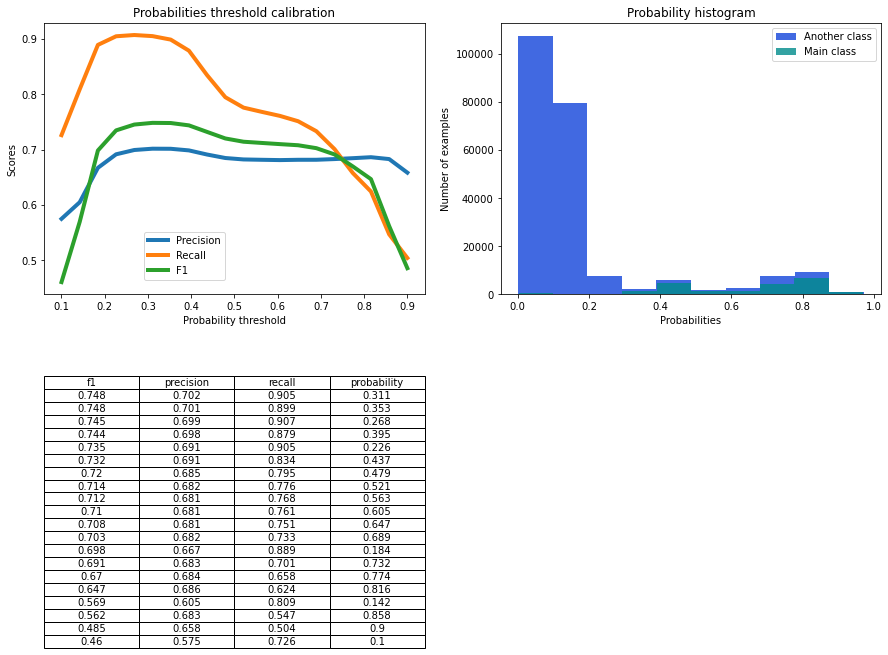

In [45]:
y_pred_probs = model_xgb.predict_proba(X_test)
show_proba_calibration_plots(y_pred_probs[:, 1], y_test)

In [47]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'feature_importance':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="feature_importance", y="Feature", data=feature_imp.sort_values(by="feature_importance", 
                                                        ascending=False)[0:num])
    plt.title('Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

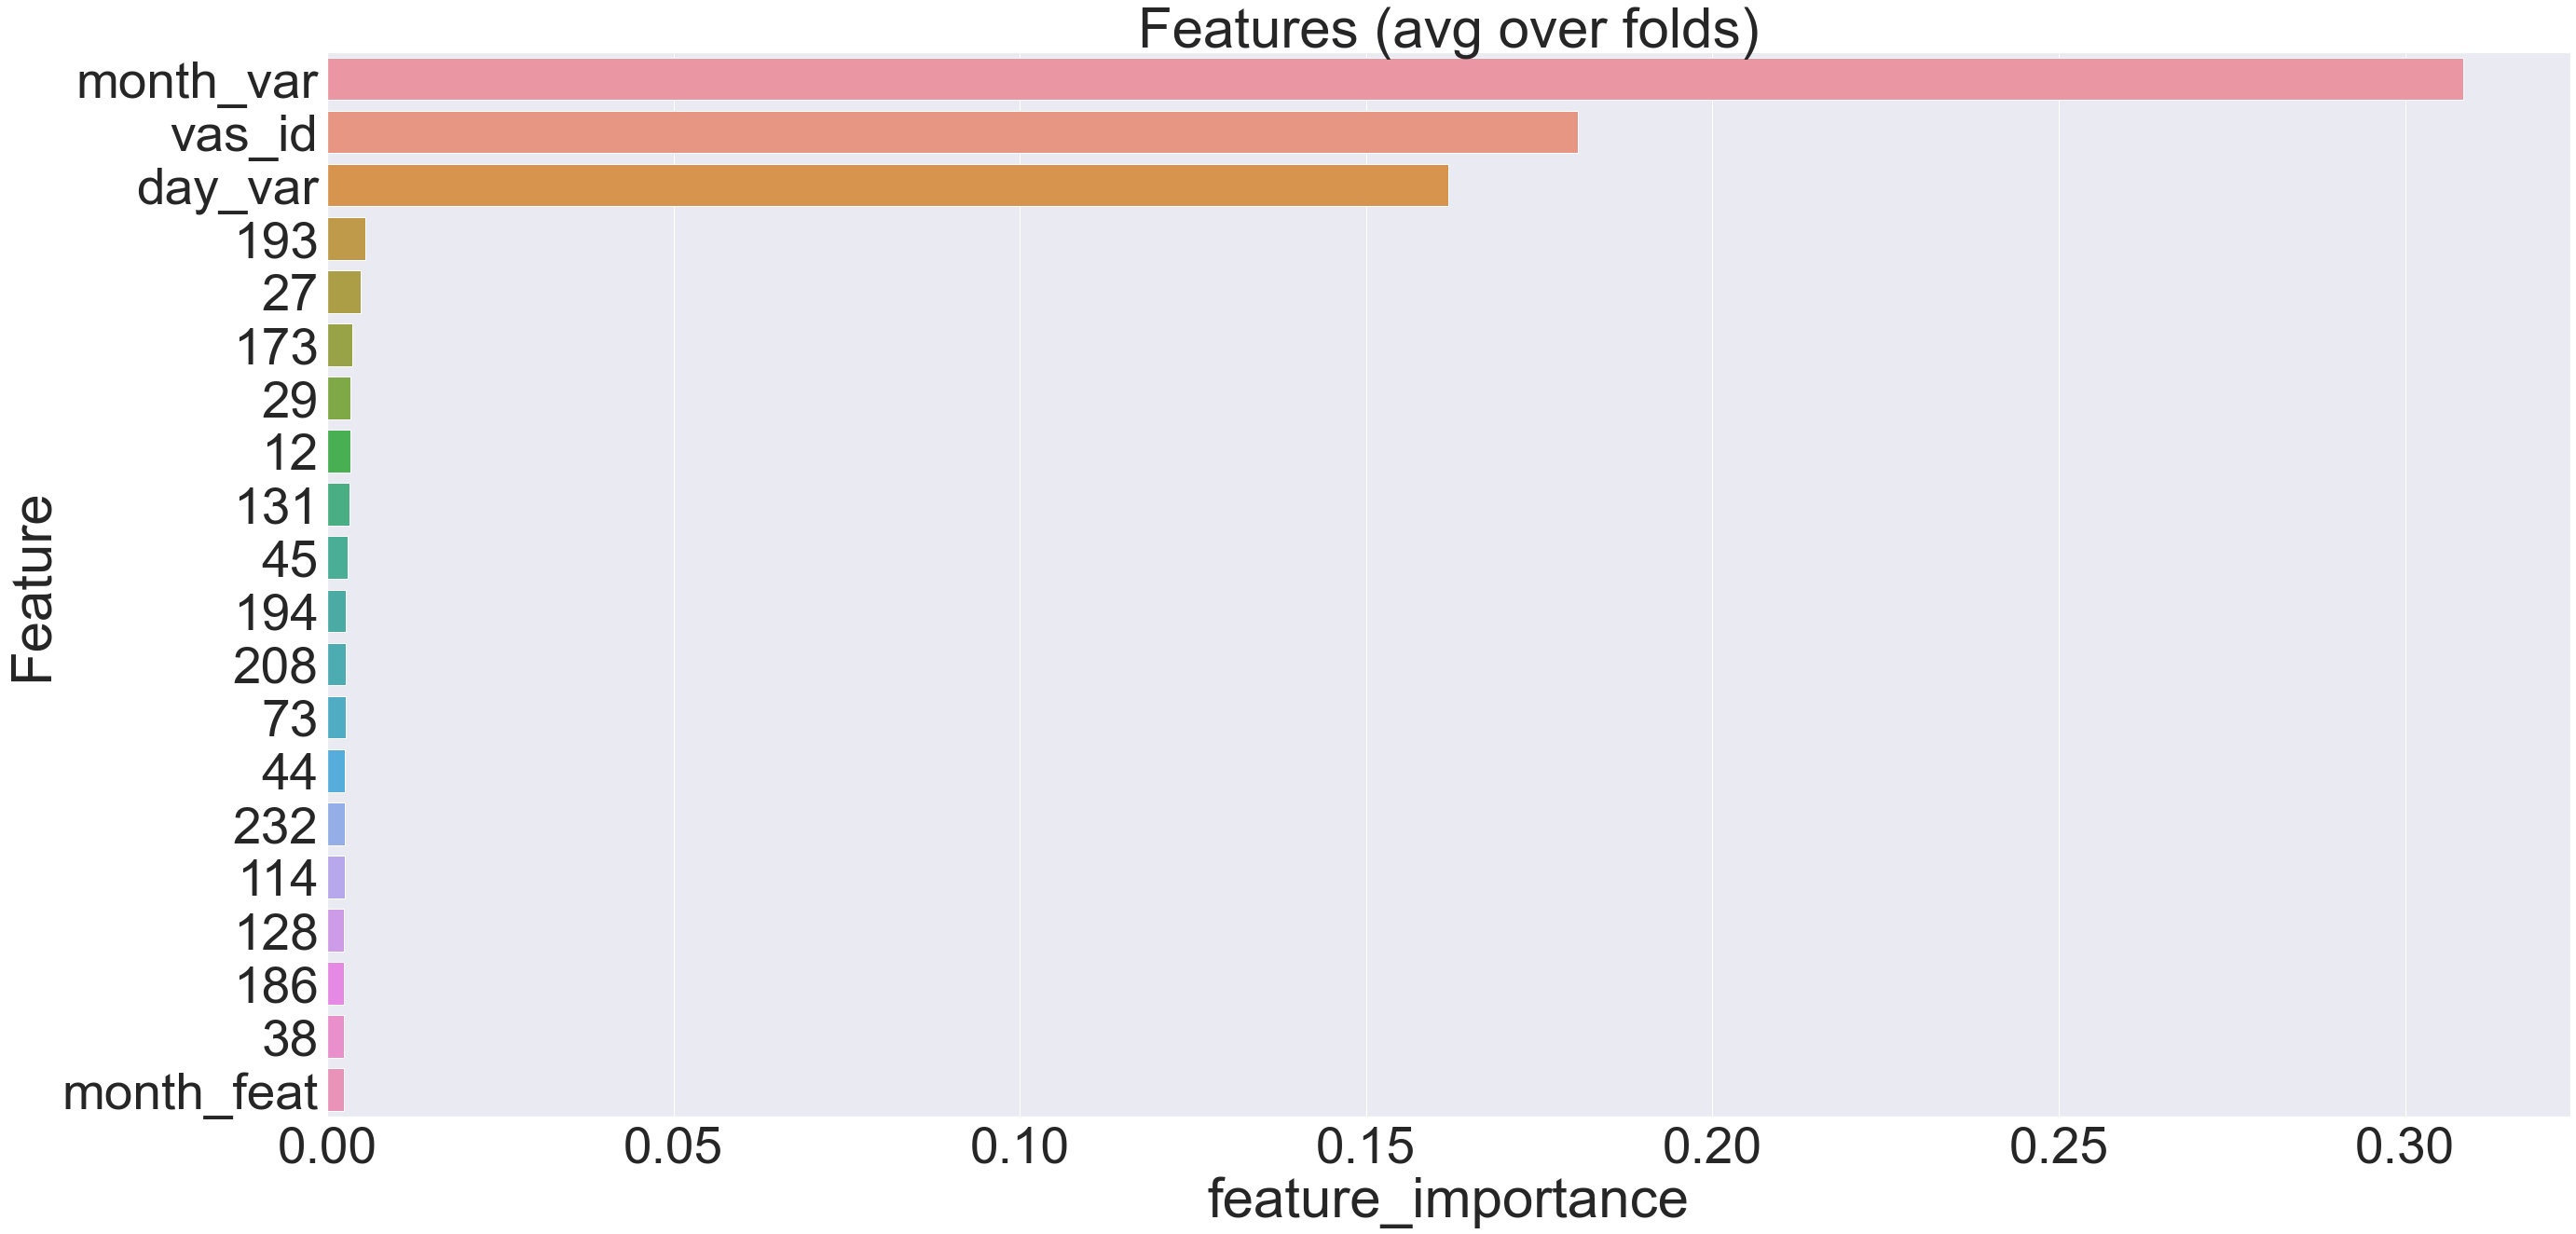

In [48]:
plotImp(model_xgb, X_train)

## Создание финальных предсказаний

Приобразуем тестовые данные

In [56]:
def change_test(df_test, df_features):
    df_features_test = df_features.loc[df_features['id'].isin(df_test['id'])].compute()
    change_type(df_features_test)
    df_features_test = df_test.merge(df_features_test, on=['id'], how='left')
    df_test_dupl = df_features_test[df_features_test[['id', 'Unnamed: 0_x']].duplicated(keep=False)] \
                                [['Unnamed: 0_x', 'id', 'buy_time_x', 'buy_time_y']]
    
    df_test_dupl['diff'] = abs(df_test_dupl['buy_time_x'] - df_test_dupl['buy_time_y'])
    df_test_dupl.sort_values(by = ['Unnamed: 0_x', 'diff'], inplace=True)
    df_test_dupl = df_test_dupl.loc[df_test_dupl[['id', 'Unnamed: 0_x']].duplicated()]
    df_features_test = df_features_test.loc[~df_features_test.index.isin(df_test_dupl.index)]
    df_features_test.sort_values(by = 'Unnamed: 0_x', inplace=True)
    df_features_test.reset_index(drop=True, inplace=True)
    df_features_test.drop(columns=['Unnamed: 0_x', 'id', 'Unnamed: 0_y'], inplace=True)
    df_features_test['buy_time_x'] = df_features_test['buy_time_x'].apply(lambda x: datetime.fromtimestamp(x))
    df_features_test['buy_time_y'] = df_features_test['buy_time_y'].apply(lambda x: datetime.fromtimestamp(x))
    df_features_test['year_var'] = df_features_test['buy_time_x'].dt.year
    df_features_test['month_var'] = df_features_test['buy_time_x'].dt.month
    df_features_test['day_var'] = df_features_test['buy_time_x'].dt.day

    df_features_test['year_feat'] = df_features_test['buy_time_y'].dt.year
    df_features_test['month_feat'] = df_features_test['buy_time_y'].dt.month
    df_features_test['day_feat'] = df_features_test['buy_time_y'].dt.day
    df_features_test.drop(columns=['buy_time_x', 'buy_time_y'], inplace=True)
    return df_features_test

In [57]:
df_features_test = change_test(df_test, df_features)

In [58]:
df_features_test.head(2)

,vas_id,0,1,2,3,4,5,6,7,8,...,249,250,251,252,year_var,month_var,day_var,year_feat,month_feat,day_feat
0,2.0,-62.899971,-374.279114,-72.600784,-418.406799,-78.018250,-439.51178,17.81382,-31.176098,-6.78366,...,-0.694429,-12.175933,-0.45614,0.0,2019,1,21,2018,9,10
1,4.0,-96.799973,100.290886,-110.740784,140.903198,-116.158249,119.79821,-16.08618,-65.076096,-6.78366,...,-0.694429,-12.175933,-0.45614,0.0,2019,1,21,2018,7,23


Создание финальной модели

In [ ]:
model_xgb = XGBClassifier(random_state=RS_MODEL, 
                                n_estimators=1057,
                                max_depth=2,
                                reg_lambda=2.0
                                )
model_xgb.fit(df_features_train.drop(columns=['target']), df_features_train['target'])

In [66]:
answer_proba = model_lgbm.predict_proba(df_features_test)

In [63]:
df_test['target'] = answer_proba[:, 1]

In [68]:
df_test.to_csv('./answers_test.csv', index=False, encoding='utf-8', sep=',')

In [70]:
import pickle
pickle.dump(model_lgbm, open('model_lgbm.pickle', 'wb'))